# Voronoi-Otsu-labeling
This workflow for image segmentation is a rather simple and yet powerful approach, e.g. for detecting and segmenting nuclei in fluorescence micropscopy images. A nuclei marker such as nuclei-GFP, DAPI or histone-RFP in combination with various microscopy techniques can be used to generate images of suitable kind.

In [23]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
import napari_segment_blobs_and_things_with_membranes as nsbatwm

from skimage import data
import napari
import numpy as np

In [35]:
viewer = napari.Viewer(ndisplay=3)

To demonstrate the workflow, we're using image data from scikit-image's [data module](https://scikit-image.org/docs/stable/api/skimage.data.html). More precisely, we'll use the `cells3d` dataset. Upon inspection of the shape of the data, we see that it's a 3D image stack with two channels:

In [36]:
input_image = data.cells3d()
input_image.shape

(60, 2, 256, 256)

In [37]:
def make_all_layers_invisible(viewer):
    for layer in viewer.layers:
        layer.visible = False

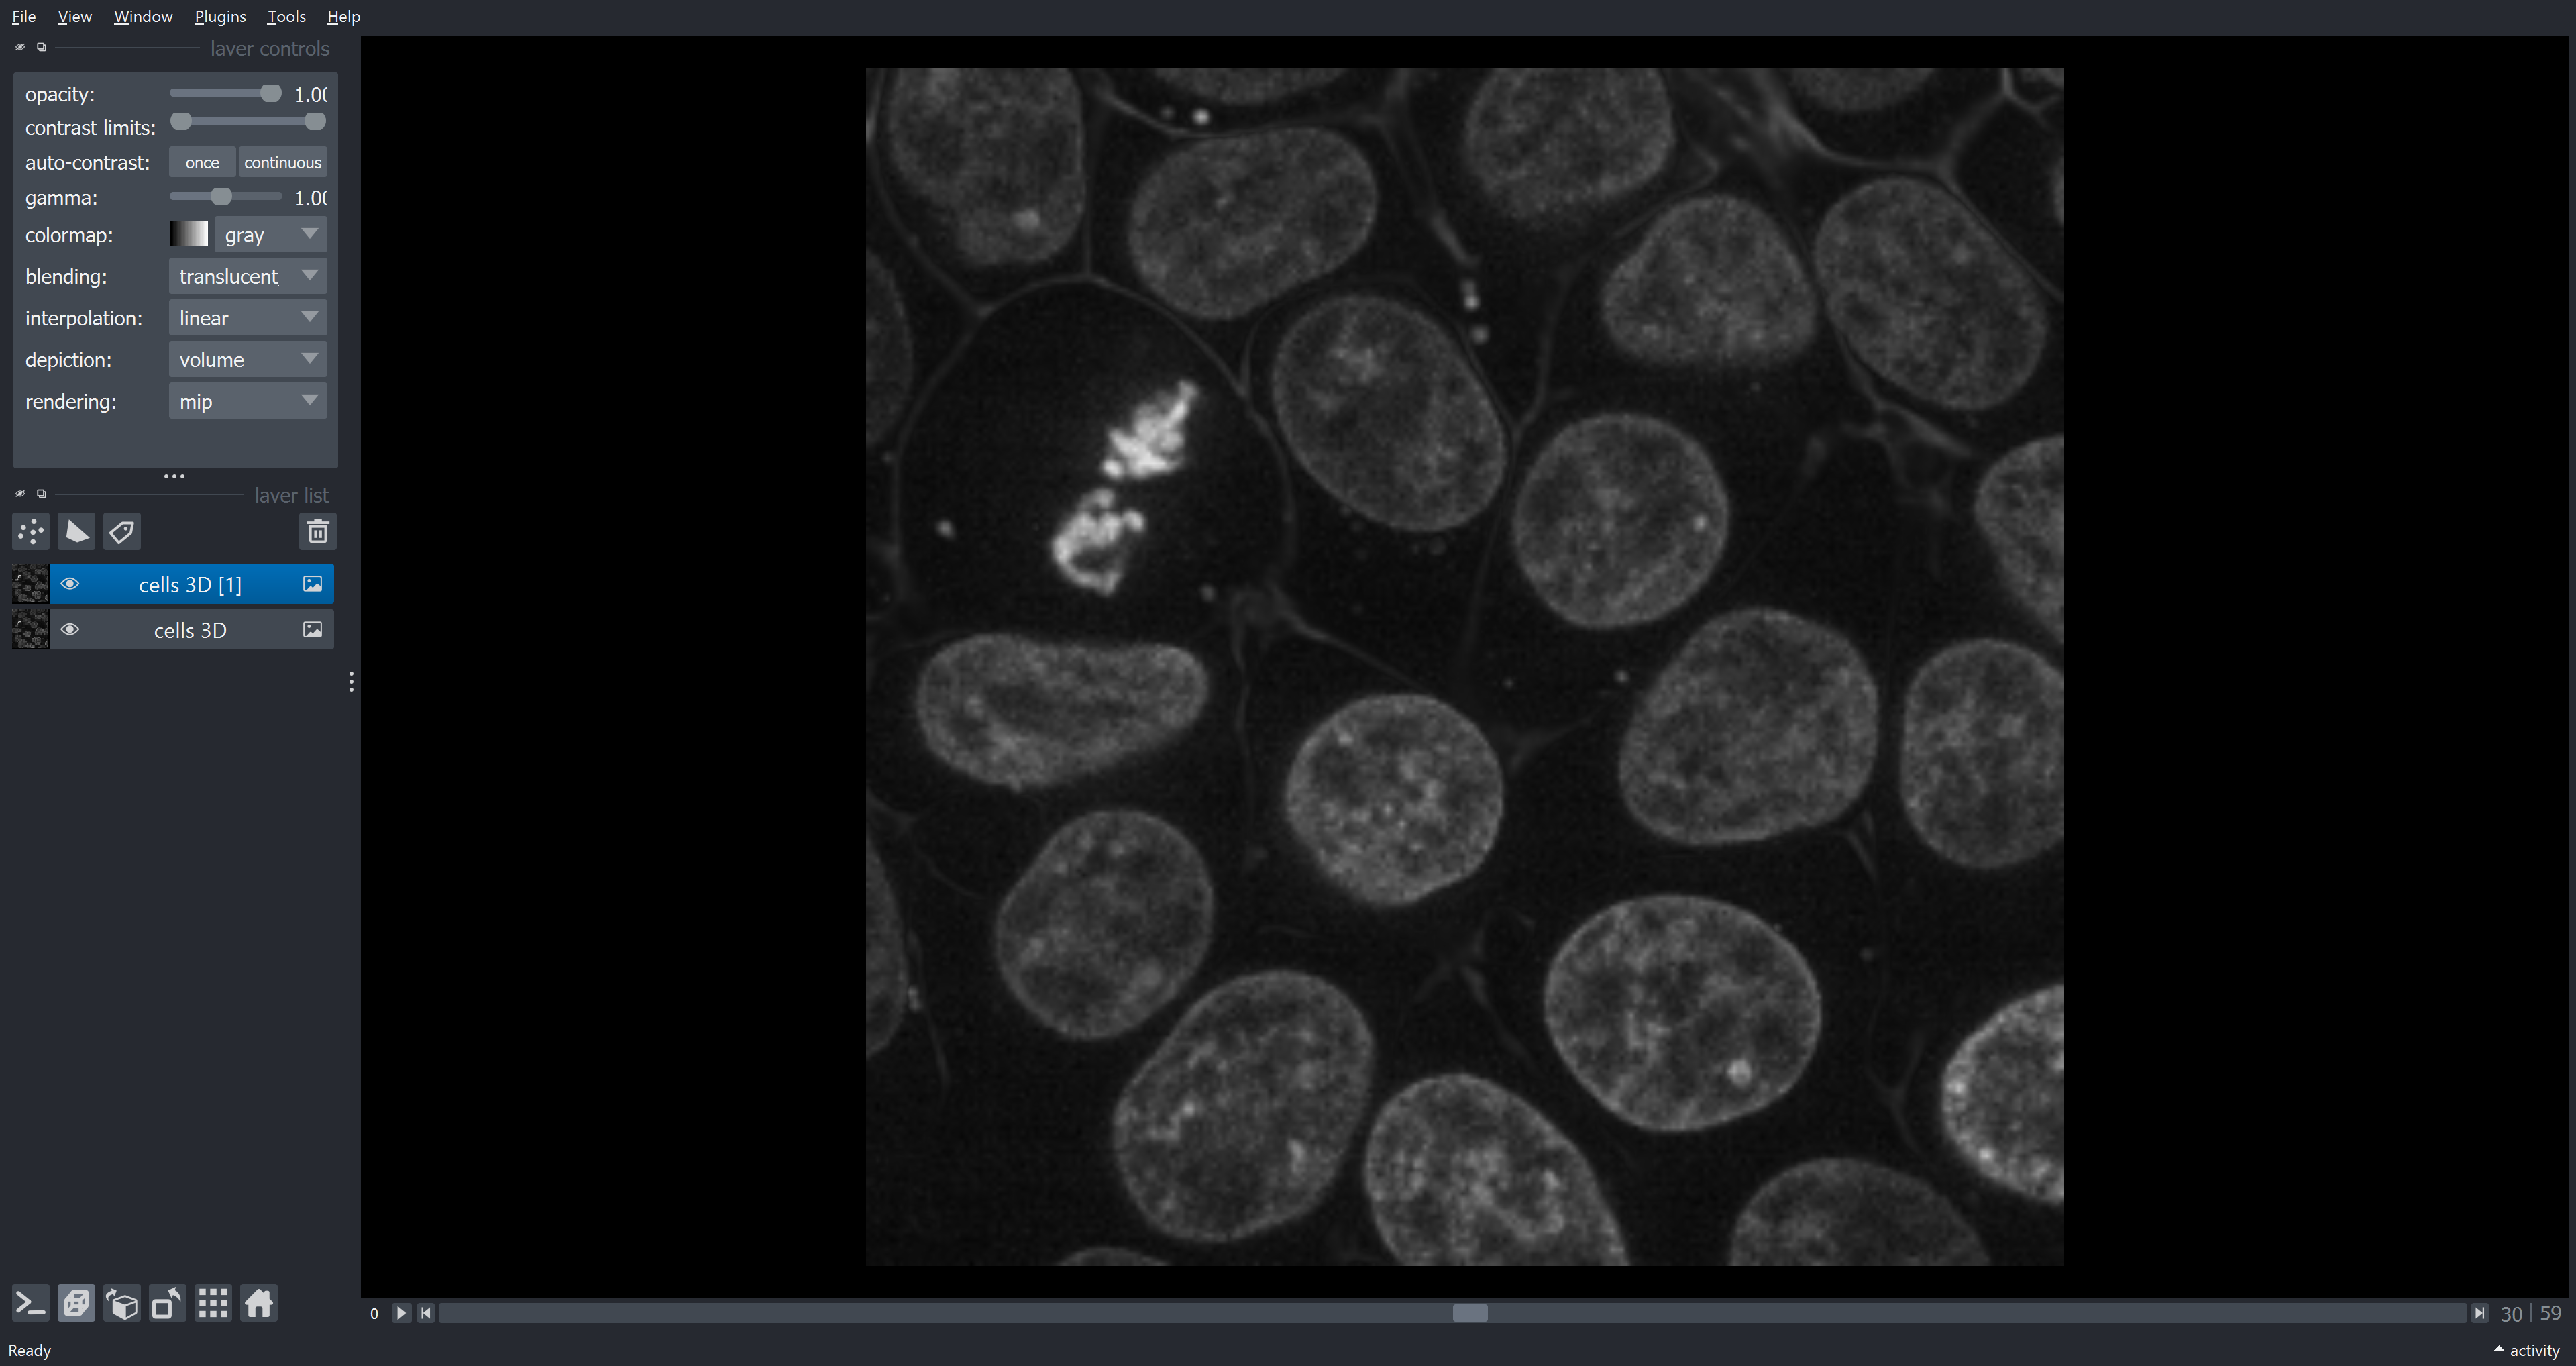

In [39]:
viewer.add_image(input_image, name='cells 3D')
napari.utils.nbscreenshot(viewer)

## Exercise 1:

Get the color channel that contains only the nuclei! Remember what you learned from the section about indexing.

In [27]:
nuclei_channel = input_image[???]
membrane_channel = input_image[???]

make_all_layers_invisible(viewer)
viewer.add_image(nuclei_channel, name='nuclei', colormap='magenta', blending='additive')
viewer.add_image(membrane_channel, name='membrane', colormap='cyan', blending='additive')

<Image layer 'membrane' at 0x23086df3ac0>

## Applying the algorithm
Voronoi-Otsu-labeling is a command in clesperanto, which asks for two sigma parameters. The first sigma controls how close detected cells can be (`spot_sigma`) and second controls how precise segmented objects are outlined (`outline_sigma`). To be faster with finding good parameters, you can also call the algorithm from the napari viewer (`Tools > Segmentation / labelling > Voronoi-otsu-labelling`).

In [28]:
sigma_spot_detection = 8
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(nuclei_channel, spot_sigma=sigma_spot_detection, outline_sigma=sigma_outline)

viewer.add_labels(segmented, name='segmented')

<Labels layer 'segmented' at 0x230937701c0>

## How does it work?
The Voronoi-Otsu-Labeling workflow is a combination of Gaussian blur, spot detection, thresholding and binary watershed. The interested reader might want to see the [open source code](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/pyclesperanto_prototype/_tier9/_voronoi_otsu_labeling.py). The approach is similar to applying a seeded watershed to a binary image, e.g. in [MorphoLibJ](https://imagej.net/plugins/marker-controlled-watershed) or [scikit-image](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed). However, the seeds are computed automatically and cannot be passed.

*Note:* If this algorithm is applied to 3D data, it is recommended to make it isotropic first. As a first step, we blur the image with a given sigma and detect maxima in the resulting image. 

In [29]:
blurred = cle.gaussian_blur(nuclei_channel, sigma_x=sigma_spot_detection, sigma_y=sigma_spot_detection, sigma_z=sigma_spot_detection)
detected_spots = cle.detect_maxima_box(blurred, radius_x=0, radius_y=0, radius_z=0)

number_of_spots = cle.sum_of_all_pixels(detected_spots)
print("number of detected spots", number_of_spots)

make_all_layers_invisible(viewer)
viewer.add_image(blurred, name="blurred")
viewer.add_points(np.argwhere(detected_spots), name="detected_spots", size=5)

number of detected spots 31.0


<Points layer 'detected_spots' at 0x230938cbe20>

Furthermore, we start again from the cropped image and blur it again, with a different sigma. Afterwards, we threshold the image using [Otsu's thresholding method (Otsu et al 1979)](https://doi.org/10.1109%2FTSMC.1979.4310076).

In [30]:
blurred = cle.gaussian_blur(nuclei_channel, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)
binary = cle.threshold_otsu(blurred)

viewer.add_labels(binary, name="binary outline")

<Labels layer 'binary outline' at 0x23086346070>

Afterwards, we take the binary spots image and the binary segmentation image and apply a `binary_and` operation to exclude spots which were detected in the background area. Those likely corresponded to noise.

In [31]:
selected_spots = cle.binary_and(binary, detected_spots)

number_of_spots = cle.sum_of_all_pixels(selected_spots)
print("number of selected spots", number_of_spots)

viewer.add_points(np.argwhere(detected_spots), size=3, name="detected spots excluding background", face_color='red')

number of selected spots 27.0


<Points layer 'detected spots excluding background' at 0x23084b53550>

Next, we separate the image space between the selected spots using a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram#References) which is limited to the positive pixels in the binary image.

In [32]:
voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, binary)
viewer.add_labels(voronoi_diagram, name='voronoi diagram', blending='additive')

<Labels layer 'voronoi diagram' at 0x230863f2400>

## Other Voronoi-Otsu-Labeling implementations

There is an alternative implementation of the algorithm in the scriptable napari plugin [napari-segment-blobs-and-things-with-membranes](https://github.com/haesleinhuepf/napari-segment-blobs-and-things-with-membranes).

The code here is almost identical to the code above. The major difference is that we call `nsbatwm.voronoi_otsu_labeling()` instead of `cle.voronoi_otsu_labeling()`.

In [33]:
sigma_spot_detection = 10
sigma_outline = 2

segmented2 = nsbatwm.voronoi_otsu_labeling(nuclei_channel, spot_sigma=sigma_spot_detection, outline_sigma=sigma_outline)

viewer.add_labels(segmented2, name='voronoi_otsu_labeling_nsbatwm', blending='additive', opacity=0.5)

<Labels layer 'voronoi_otsu_labeling_nsbatwm' at 0x23086dd44c0>

## Exercise 2:

Tune the parameters of the Voronoi-Otsu thresholding algorithm to get a better segmentation of the cells.